# Cats and Dogs Classifier: Working on large datasets

Steps of solving the problem:
1. Data Exploration
2. Segregate the dataset that is accepted by the ImageDataGenerator.
3. Design the model
4. Compile the model
5. Code the datagenerator considering batch size
6. Train
7. Validate
8. Training and validation plots
9. Test on other images
10. Miscellaneous

## 1. Data Exploration

In [32]:
import os
import matplotlib.pyplot as plt

In [33]:
# Reading the dataset
dataset_path = "D:\\local_ws\\datasets\\cats-and-dogs\\PetImages\\"

dog_img_names = os.listdir(dataset_path + "Dog")
cat_img_names = os.listdir(dataset_path + "Cat")
print("dog images: ", len(dog_img_names))
print("cat images: ", len(cat_img_names))

dog images:  12470
cat images:  12491


Image shape:  (375, 500, 3)


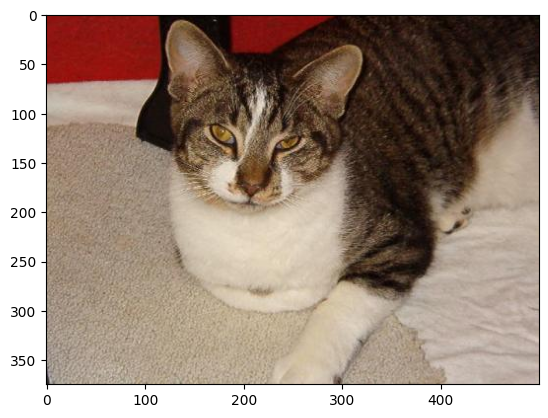

In [34]:
import random
index = random.randint(0,100)
img = plt.imread(dataset_path + "Cat\\" + cat_img_names[index])
plt.imshow(img)
print("Image shape: ", img.shape)

Observations about the data:
1. The images are of variable resolution
2. The images are RGB

Hence, image resizing becomes important to input into a CNN.

## 2. Data Segregation into suitable directories

In [35]:
# Segregating the images, so ImageDataGenerator can label them

data_path = "D:\\local_ws\\datasets\\cats-and-dogs\\"

# making directory structure
os.mkdir(data_path + "c-n-d")
os.mkdir(data_path + "c-n-d\\training")
os.mkdir(data_path + "c-n-d\\training\\cats")
os.mkdir(data_path + "c-n-d\\training\\dogs")
    
os.mkdir(data_path + "c-n-d\\testing")
os.mkdir(data_path + "c-n-d\\testing\\cats")
os.mkdir(data_path + "c-n-d\\testing\\dogs")

In [36]:
from shutil import copyfile

def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    '''
    Arguments:
    SOURCE: path to the directory containing images in str format
    TRAINING: path to the directory where training images need to be stored
    TESTING: path to the directory where testing images need to be stored
    SPLIT_SIZE: test-train split in fraction, training fraction
    '''
    # storing all file names in a directory in a list
    files = []
    for fname in os.listdir(SOURCE):
        fpath = SOURCE + fname
        if os.path.getsize(fpath) > 0:
            files.append(fname)
        else:
            print(fname + " is zero length, so ignoring.")

    # creating training and testing sets with file names
    total_files = len(files)
    training_length = int(total_files * SPLIT_SIZE)
    testing_length = int(total_files - training_length)
    shuffled_set = random.sample(files, total_files)
    training_set = shuffled_set[:training_length]
    testing_set = shuffled_set[-testing_length:]
    
    # copying these files to the training and tesing folders
    # Note the directory structure should be
    # CLASS FOLDER ------> 2 FOLDERS (training and validation)
    for fname in training_set:
        fpath = SOURCE + fname
        destination_path = TRAINING + fname
        copyfile(fpath, destination_path)

    for fname in testing_set:
        fpath = SOURCE + fname
        destination_path = TESTING + fname
        copyfile(fpath, destination_path)

In [37]:
# Splitting the dataset into training and testing
CAT_SOURCE_DIR = dataset_path + "Cat\\"
TRAINING_CATS_DIR = data_path + "c-n-d\\training\\cats\\"
TESTING_CATS_DIR = data_path + "c-n-d\\testing\\cats\\"

DOG_SOURCE_DIR = dataset_path + "Dog\\"
TRAINING_DOGS_DIR = data_path + "c-n-d\\training\\dogs\\"
TESTING_DOGS_DIR = data_path + "c-n-d\\testing\\dogs\\"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [38]:
# Checking the number of files in the directories
print(
    "Cats:",
    len( os.listdir(TRAINING_CATS_DIR) ),
    len( os.listdir(TESTING_CATS_DIR) ),
    "Dogs:",
    len( os.listdir(TRAINING_DOGS_DIR) ),
    len( os.listdir(TESTING_DOGS_DIR) ),
    sep="\n"
)

Cats:
11241
1250
Dogs:
11223
1247


## 3,4. Designing and compiling the model

In [40]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # 3 conv-maxpool layers, with 1 flatten and 2 dense
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')   # as only 2 classes
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 64)        0

In [41]:
from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=0.001),
    metrics=['acc']
)

## 5. Coding the datagenerator

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = data_path + "c-n-d\\training\\"
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size = 250,
    class_mode='binary',
    target_size=(150,150)
) 

TEST_DIR = data_path + "c-n-d\\testing\\"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size = 250,
    class_mode = 'binary',
    target_size=(150,150)
)

Found 22462 images belonging to 2 classes.
Found 2497 images belonging to 2 classes.


## 6,7. Training the network

In [46]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs = 15,
    steps_per_epoch = 90,
    validation_steps=6
)

Epoch 1/15
71/90 [======================>.......] - ETA: 20s - loss: 0.7014 - acc: 0.5450

C:\Users\asish\AppData\Local\Programs\Python\Python311\Lib\site-packages\PIL\TiffImagePlugin.py:866: UserWarning: Truncated File Read
  warnings.warn(str(msg))


90/90 [==============================] - 103s 1s/step - loss: 0.6927 - acc: 0.5572 - val_loss: 0.6204 - val_acc: 0.6980
Epoch 2/15
90/90 [==============================] - 101s 1s/step - loss: 0.5997 - acc: 0.6783 - val_loss: 0.5477 - val_acc: 0.7287
Epoch 3/15
90/90 [==============================] - 100s 1s/step - loss: 0.5543 - acc: 0.7094 - val_loss: 0.6247 - val_acc: 0.6260
Epoch 4/15
90/90 [==============================] - 99s 1s/step - loss: 0.5137 - acc: 0.7411 - val_loss: 0.4822 - val_acc: 0.7627
Epoch 5/15
90/90 [==============================] - 99s 1s/step - loss: 0.4852 - acc: 0.7616 - val_loss: 0.4421 - val_acc: 0.7880
Epoch 6/15
90/90 [==============================] - 100s 1s/step - loss: 0.4609 - acc: 0.7803 - val_loss: 0.4443 - val_acc: 0.7960
Epoch 7/15
90/90 [==============================] - 104s 1s/step - loss: 0.4262 - acc: 0.7991 - val_loss: 0.4570 - val_acc: 0.7853
Epoch 8/15
90/90 [==============================] - 113s 1s/step - loss: 0.4005 - acc: 0.8154 - 

## 8. Training and validation plots

<Figure size 640x480 with 0 Axes>

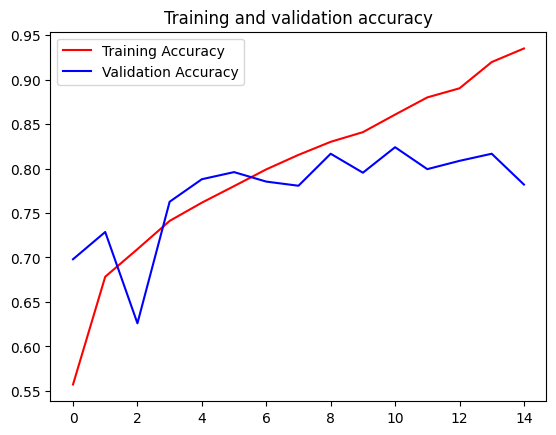

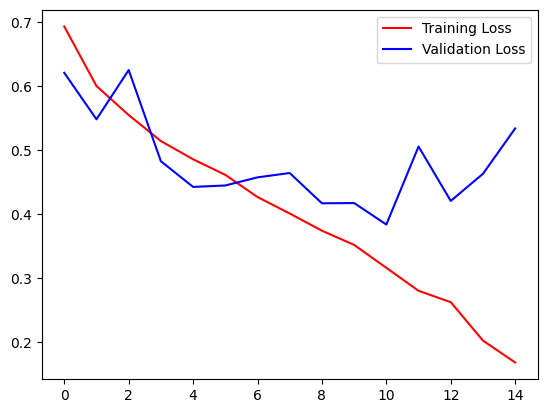

<Figure size 640x480 with 0 Axes>

In [52]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# retrieve a list of results on training and test data sets for each epoch
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))   # get number of epochs

# plotting the training and validation accuracy per epoch
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

# plotting traininf and validation loss per epoch
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.legend()
plt.figure()

## 9. Testing on other images

In [64]:
import numpy as np
# library to upload files
from keras.preprocessing import image
import os

def prediction(image_path):
    '''
    image_path: a string with path to the image
    '''
    img = image.load_img(image_path, target_size=(150,150))
    img_array = image.img_to_array(img)
    img_array = img_array / 255
    img_array = np.expand_dims(img_array, axis=0)
    images = np.vstack([img_array])
    classes = model.predict(images, batch_size=10)
    print(classes[0])

    fname = str(image_path.split("\\")[-1])
    if classes[0] > 0.5:
        print(fname + " is a dog")
    else:
        print(fname + " is a cat")


folder = "D:\\local_ws\\datasets\\cats-and-dogs\\extra_images\\"
for image_no in range(1,8):
    prediction(folder + " (" + str(image_no) + ")"+".jpg")
# "D:\local_ws\datasets\cats-and-dogs\extra_images\ (1).jpg"
# a = plt.imread(folder + " (" + str(1) + ")"+".jpg")
# plt.imshow(a)

1/1 [==============================] - 0s 20ms/step
[0.21327958]
 (1).jpg is a cat
1/1 [==============================] - 0s 20ms/step
[0.66112465]
 (2).jpg is a dog
1/1 [==============================] - 0s 22ms/step
[0.5565002]
 (3).jpg is a dog
1/1 [==============================] - 0s 21ms/step
[0.4595704]
 (4).jpg is a cat
1/1 [==============================] - 0s 20ms/step
[0.00072959]
 (5).jpg is a cat
1/1 [==============================] - 0s 20ms/step
[0.27647704]
 (6).jpg is a cat
1/1 [==============================] - 0s 19ms/step
[0.56776893]
 (7).jpg is a dog
